In [1]:
# prepare the environment

#for data
import numpy as np
import pandas as pd

#for plotting
import matplotlib.pyplot as plt
import seaborn as sns

#for statistical test
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

#for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition

#for explainer
from lime import lime_tabular

In [2]:
##read the data
df=pd.read_csv('./titanic/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
#identify data is categorical or numerical
def find_cat(df, col, max_cat=20):
    if (df[col].dtype == 'O') | (df[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

In [4]:
dic_cols=dict()
for col in df.columns:
    tipe=find_cat(df, col, max_cat=20)
    dic_cols.update({col:tipe})
dic_cols

{'PassengerId': 'num',
 'Survived': 'cat',
 'Pclass': 'cat',
 'Name': 'cat',
 'Sex': 'cat',
 'Age': 'num',
 'SibSp': 'cat',
 'Parch': 'cat',
 'Ticket': 'cat',
 'Fare': 'num',
 'Cabin': 'cat',
 'Embarked': 'cat'}

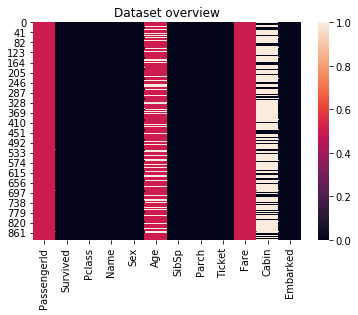

 Categorical  Numeric  Nan


In [5]:
#visualize the proportion cateogorical, numerical and Nan of the dataset using heatmap

#analyze Nan value
heatmap=df.isnull()

for k, v in dic_cols.items():
    if v == 'num':
        heatmap[k]=heatmap[k].apply(lambda x: 0.5 if x is False else 1)
    else:
        heatmap[k]=heatmap[k].apply(lambda x: 0 if x is False else 1)

sns.heatmap(heatmap, cbar=True).set_title('Dataset overview')
plt.show()
print('\033[1;37;40m Categorical', '\033[1;37;41m Numeric', '\033[1;30;47m Nan')


In [6]:
# set passenger id as primary key or index
df=df.set_index(df['PassengerId'])

#set survived column as y because its parameter we want to know
df=df.rename(columns={'Survived':'Y'})


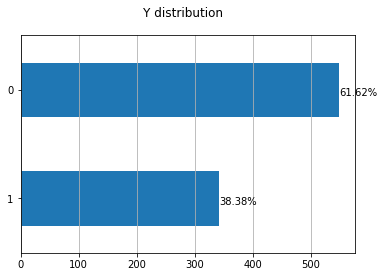

In [7]:
#visualize univariate distribution
y= 'Y'
ax=df[y].value_counts().sort_values().plot(kind='barh')
totals=[]
for i in ax.patches:
    totals.append(i.get_width())
total=sum(totals)
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.2, str(round((i.get_width()/total)*100, 2))+'%', fontsize=10, color='black')
ax.grid(axis='x')
plt.suptitle('Y distribution')
plt.show()

/home/edi/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


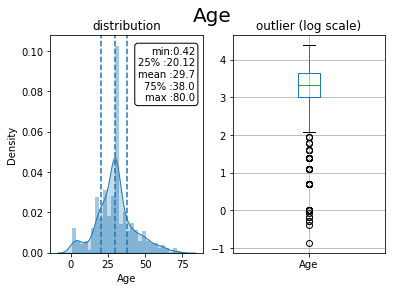

In [8]:
x='Age'

fig, ax=plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
fig.suptitle(x, fontsize=20)

## distribution
ax[0].title.set_text('distribution')
variable=df[x].fillna(df[x].mean())
breaks=np.quantile(variable, q=np.linspace(0, 1, 11))
variable= variable[(variable>breaks[0]) & (variable<breaks[10])]
sns.distplot(variable, hist=True, kde=True, kde_kws={'shade':True}, ax=ax[0])
des=df[x].describe()
ax[0].axvline(des['25%'], ls='--')
ax[0].axvline(des['mean'], ls='--')
ax[0].axvline(des['75%'], ls='--')
des=round(des, 2).apply(lambda x: str(x))
box='\n'.join(('min:'+des['min'], '25% :'+des['25%'], 'mean :'+des['mean'], '75% :'+des['75%'], 'max :'+des['max']))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha='right', bbox=dict(boxstyle='round'
                                                                                                   , facecolor='white'
                                                                                                   , alpha=1))

## boxplot
ax[1].title.set_text('outlier (log scale)')
tmp_df=pd.DataFrame(df[x])
tmp_df[x]=np.log(tmp_df[x])
tmp_df.boxplot(column=x, ax=ax[1])

plt.show()


/home/edi/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/edi/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


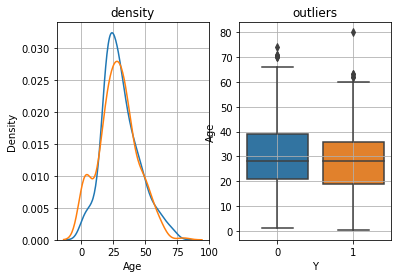

In [37]:
cat, num= 'Y', 'Age'
fig, ax=plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
#fig.suptitle(x+" vs "+y, fontsize=20)
##distribution
ax[0].title.set_text('density')
for i in df[cat].unique():
    sns.distplot(df[df[cat]==i][num], hist=False, label=i, ax=ax[0])
ax[0].grid(True)

##boxplot
ax[1].title.set_text('outliers')
sns.boxplot(x=cat, y=num, data=df, ax=ax[1])
ax[1].grid(True)

plt.show()


In [10]:
## ANOVA testing

cat, num= 'Y', 'Age'

model = smf.ols(num+' ~ '+cat, data=df).fit()
table=sm.stats.anova_lm(model)
p=table['PR(>F)'][0]
coeff, p= None, round(p, 3)
if p < 0.05:
    print('The variables are correlated','(p-value :{})'.format(p))
else:
    print('The variables are not correlated', '(p-value :{})'.format(p))

The variables are correlated (p-value :0.039)


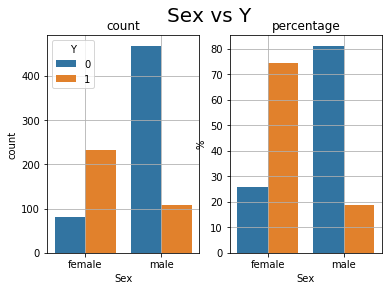

<class 'pandas.core.frame.DataFrame'>


In [35]:
## analisis categorical vs categorical 

x, y='Sex', 'Y'

fig, ax=plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
fig.suptitle(x+' vs '+y, fontsize=20)

##count
ax[0].title.set_text('count')
order=df.groupby(x)[y].count().index.tolist()
sns.countplot(x=x, hue=y, data=df,  order=order, ax=ax[0])
ax[0].grid(True)

##percentage
ax[1].title.set_text('percentage')
a=df.groupby(x)[y].count().reset_index()
a=a.rename(columns={y:'tot'})
b=df.groupby([x, y])[y].count()
b=pd.DataFrame(b)
b = b.rename(columns={'Y':0}).reset_index()
b=b.merge(a, how='left')
b['%']=(b[0]/b['tot'])*100
sns.barplot(x=x, y='%', hue=y, data=b,ax=ax[1]).get_legend().remove()
ax[1].grid(True)

plt.show()


In [47]:
## uji chisquare
x, y = 'Sex', 'Y'

cont_table=pd.crosstab(index=df[x], columns=df[y])
print(cont_table)
chi2_test=scipy.stats.chi2_contingency(cont_table)
chi2, p=chi2_test[0], chi2_test[1]
print('chi2 value : {}'.format(chi2))
print('p-value : {}'.format(p))
n=cont_table.sum().sum()
phi2=chi2/n
ro, col=cont_table.shape
phi2corr=max(0, phi2-((col-1)*(ro-1)/(n-1)))

Y         0    1
Sex             
female   81  233
male    468  109
chi2 value : 260.71702016732104
p-value : 1.1973570627755645e-58
